In [1]:
%%writefile 'planets_project.py'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import json
import random
from dataclasses import dataclass

@dataclass
class Planet:
    mass: float
    position: np.ndarray
    velocity: np.ndarray

    def __init__(self, mass: float, position_array: list[float], velocity_array: list[float]):
        self.mass = mass
        self.position = np.array(position_array)
        self.velocity = np.array(velocity_array)



def load_from_json(filename: str):
    f = open(filename)

    json_dict = json.load(f)

    planets = []
    for value in json_dict.values():
        planets.append(Planet(value['mass'], value['position'], value['velocity']))

    f.close()

    return planets


def generate_random_planets(n):

    planets = []

    for i in range(n):
        mass = np.random.uniform(1e26, 1e27)
        position = [np.random.uniform(-1e11, 1e11),np.random.uniform(-1e11, 1e11)]
        velocity = [np.random.uniform(-1e3, 1e3),np.random.uniform(-1e3, 1e3)]

        planets.append(Planet(mass, position, velocity))

    return planets



class SystemOfPlanets:
    planets: list[Planet]
    planet_count: int

    masses: np.ndarray
    positions: np.ndarray
    velocities: np.ndarray

    distances: np.ndarray
    directions: np.ndarray
    forces: np.ndarray
    accels: np.ndarray

    positions_in_time: list[np.ndarray]


    def __init__(self, planets: list[Planet]):
        self.planets = planets
        self.count = len(planets)
        self.masses = np.array([p.mass for p in planets])
        self.positions = np.array([p.position for p in planets])
        self.velocities = np.array([p.velocity for p in planets])

        self.distances =  np.zeros((self.count,self.count))       #[[0 for _ in range(self.count)] for _ in range(self.count)]
        self.directions = np.zeros((self.count,self.count,2))     #[[[0,0] for _ in range(self.count)] for _ in range(self.count)]
        self.forces = np.zeros((self.count,self.count,2))         #[[[0,0] for _ in range(self.count)] for _ in range(self.count)]
        self.accels = np.zeros((self.count,2))             #[[0,0] for _ in range(self.count)]
        
        self.positions_in_time = [np.copy(self.positions)]
    
    
    def calculate_distances(self):
        for i in range(self.count):
            for j in range(i+1, self.count):
                diff = self.positions[j] - self.positions[i]
                dist = np.linalg.norm(diff)
                direction = diff / dist

                self.distances[i][j] = dist
                self.distances[j][i] = dist
                self.directions[i][j] = direction
                #self.directions[j][i] = -direction
                

    def calculate_distances_np(self):
        diffs = self.positions[:,np.newaxis,:] - self.positions
    
        tmp_sum = np.sum(diffs*diffs, axis=-1)
        self.distances = np.sqrt(tmp_sum)
        
        self.directions = np.divide(-diffs, self.distances[:,:,np.newaxis], out=np.zeros_like(diffs), where=self.distances[:,:,np.newaxis]!=[0])


    def calculate_forces(self):
        for i in range(self.count):
            for j in range(i+1, self.count):
                G = 6.6743e-11
                force = (G*((self.masses[i] * self.masses[j])/((self.distances[i][j])**2))) * self.directions[i][j]
                self.forces[i][j] = force
                self.forces[j][i] = -force

    def calculate_forces_np(self):
        mass_products = self.masses[:,None] * self.masses
        G = 6.6743e-11
        forces = G * np.divide(mass_products, np.power(self.distances,2), out=np.zeros_like(mass_products),where=self.distances!=0)
        force_vectors = forces[:,:,np.newaxis] * self.directions
        self.forces = force_vectors
        
        
    def calculate_accelerations(self):
        for i in range(self.count):
            total_force = np.sum(self.forces[i],axis=(0))


            self.accels[i] = total_force / self.masses[i]

    def calculate_accelerations_np(self):
       total_forces = np.sum(self.forces,axis=(1))
       self.accels = np.divide(total_forces, self.masses[:,np.newaxis])

    def move_planets(self, time_interval):
        self.calculate_distances_np()
        self.calculate_forces_np()
        self.calculate_accelerations_np()

        self.velocities += self.accels * time_interval
        self.positions += self.velocities * time_interval
        self.positions_in_time.append(np.copy(self.positions))


    def simulate_movement(self, duration, time_interval):
        for i in range(math.floor(duration / time_interval)):
            self.move_planets(time_interval)
            
            
            

    def draw_current_state(self, size):
        x_values = [p[0] for p in self.positions]
        y_values = [p[1] for p in self.positions]

        fig, axes = plt.subplots()
        axes.set_xlim([-size,size])
        axes.set_ylim([-size,size])
        dots = axes.plot(x_values, y_values,'.')
        plt.show()

    def draw_trajectories(self, size):
        fig,axes = plt.subplots()
        axes.set_xlim([-size,size])
        axes.set_ylim([-size,size])
        
        for i in range(self.count):
            x_values = [p[i][0] for p in self.positions_in_time]
            y_values = [p[i][1] for p in self.positions_in_time]

            axes.plot(x_values,y_values)
        
        plt.show()

    
    def show_animation(self, size):
        fig, ax = plt.subplots()
        ax.set_xlim([-size,size])
        ax.set_ylim([-size,size])
    
        dots, = ax.plot([p[0] for p in self.positions_in_time[0]], [p[1] for p in self.positions_in_time[0]],'.')


        def animation_frame(i):
            dots.set_xdata([p[0] for p in self.positions_in_time[i]])
            dots.set_ydata([p[1] for p in self.positions_in_time[i]])
            return dots
            
        anim = animation.FuncAnimation(fig, func=animation_frame, frames=np.arange(0, len(self.positions_in_time),1), interval=20)
        plt.show()


Overwriting planets_project.py


In [218]:
#funkce na animace
'''
def show_animation(planets: list[Planet], size, duration, time_interval):
    fig, axes = plt.subplots()
    axes.set_xlim([-size,size])
    axes.set_ylim([-size,size])
   
    dots = axes.plot([p.position[0] for p in planets], [p.position[1] for p in planets],'.')


    def animation_frame(i):
        move_planets(planets,time_interval)
        dots.set_xdata([p.position[0] for p in planets])
        dots.set_ydata([p.position[1] for p in planets])
        return dots
        
    anim = animation.FuncAnimation(fig, func=animation_frame, frames=np.arange(0, duration, time_interval), interval=20)
    plt.show()

def save_animation(planets: list[Planet], size, duration, time_interval):
    fig, axes = plt.subplots()
    axes.set_xlim([-size,size])
    axes.set_ylim([-size,size])
    axes.set_aspect(1)
    

    dots, = axes.plot([p.position[0] for p in planets], [p.position[1] for p in planets],'.', )


    def animation_frame(i):
        move_planets(planets,time_interval)
        dots.set_xdata([p.position[0] for p in planets])
        dots.set_ydata([p.position[1] for p in planets])
        return dots
        
    anim = animation.FuncAnimation(fig, func=animation_frame, frames=np.arange(0, duration*time_interval*50, time_interval), interval=20)
    anim.save('planets.mp4',writer='ffmpeg')


'''

"\ndef show_animation(planets: list[Planet], size, duration, time_interval):\n    fig, axes = plt.subplots()\n    axes.set_xlim([-size,size])\n    axes.set_ylim([-size,size])\n   \n    dots = axes.plot([p.position[0] for p in planets], [p.position[1] for p in planets],'.')\n\n\n    def animation_frame(i):\n        move_planets(planets,time_interval)\n        dots.set_xdata([p.position[0] for p in planets])\n        dots.set_ydata([p.position[1] for p in planets])\n        return dots\n        \n    anim = animation.FuncAnimation(fig, func=animation_frame, frames=np.arange(0, duration, time_interval), interval=20)\n    plt.show()\n\ndef save_animation(planets: list[Planet], size, duration, time_interval):\n    fig, axes = plt.subplots()\n    axes.set_xlim([-size,size])\n    axes.set_ylim([-size,size])\n    axes.set_aspect(1)\n    \n\n    dots, = axes.plot([p.position[0] for p in planets], [p.position[1] for p in planets],'.', )\n\n\n    def animation_frame(i):\n        move_planets(plan

In [206]:
%%timeit
G = 6.6743e-11
solar_system_np = SystemOfPlanets(load_from_json('testdata/test1.json'))
solar_system_np.calculate_distances_np()
solar_system_np.calculate_forces_np()
solar_system_np.calculate_accelerations_np()
solar_system_np.accels

264 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [207]:
%%timeit
G = 6.6743e-11
solar_system = SystemOfPlanets(load_from_json('testdata/test1.json'))
solar_system.calculate_distances()
solar_system.calculate_forces()
solar_system.calculate_accelerations()

972 µs ± 85 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


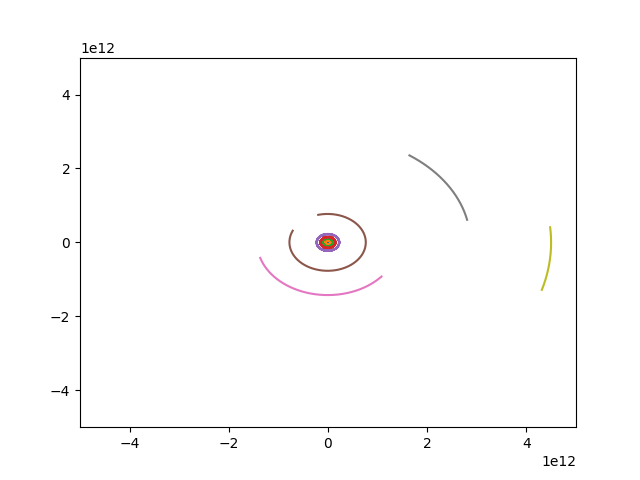

In [234]:
%matplotlib widget
import planets_project as p
solar_system = p.SystemOfPlanets(p.load_from_json('testdata/test1.json'))

solar_system.simulate_movement(60*60*24*365*10,60*60*24)

solar_system.draw_trajectories(5e12)